<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jihoyeo/mobility-simulation-book/blob/main/ko/chapter2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 2. Data Preparation

본 챕터에서는 모빌리티 시뮬레이션을 구축하는데 필요한 기본적인 입력데이터들을 살펴본다. 단순히 데이터를 살펴보는데서 끝나지 않고 간단한 데이터의 전처리 및 시각화의 실습과정도 포함하고 있다.

매우 다양한 형태의 모빌리티 데이터가 존재하며, 이들을 분류하는 기준 역시 분석자의 목표에 따라 여려가지로 구분할 수 있지만 본 책에서는 크게 아래와 같은 형태의 데이터를 살펴볼 것이다.
1. 통행수요 데이터 (Travel Demand)
    - 시뮬레이션을 하기 위한 승객의 수요를 생성하는 기초자료로 활용됨
2. 통행시간 데이터 (Travel Time)
    - 시뮬레이션을 Calibration 하는데 활용
    - e.g., 출퇴근 시간의 교통 정체, 새벽시간대의 빠른 속도를 시뮬레이션에 반영 가능함
3. 도로 네트워크 데이터 (Road Network)
    - 도로 위를 움직이는 차량 구현 (Vehicle Router)
4. 대중교통 네트워크 데이터 (Public Transit Network)
    - 버스, 지하철과 같은 노선과 배차간격이 정해진 모빌리티 시스템을 구현하는데 사용

## 2.1 Travel Demand Data (Trip record data)

### 2.1.1 활용 데이터
- 통행수요는 특정지역에서 출발(Trip Production)하거나, 특정지역으로 도착하는 통행(Trip Attraction) 형태로 존재할 수도 있고, 혹은 더 세분화 한다면 출발지-목적지 단위의 통행수요(Origin-Destination (OD) Travel Demand)로 나타낼 수 있다. 
- 최근 많은 사람들이 스마트폰을 사용하고 따라서 통신사 기지국 기반으로 세밀한 통행패턴이 수집 가능하며, O-D 단위의 통행수요 데이터를 구득하기가 수월해졌다. 따라서 본 교재에서는 O-D 단위의 통행 데이터를 주로 활용하는 실습을 진행할 예정이다. 
- 본 예제에서는 서울시에서 제공하는 수도권 생활이동 데이터를 활용하였다. 
    - https://data.seoul.go.kr/dataVisual/seoul/capitalRegionLivingMigration.do

### 2.1.2 데이터 읽기 및 간단한 전처리

- 간단한 예제를 위해 서울시에서 제공하는 [수도권 생활이동](https://data.seoul.go.kr/dataVisual/seoul/capitalRegionLivingMigration.do) 데이터 중, 2024년 3월 27일 하루치의 데이터만을 예제로 사용하였다. 
- 원활한 실습을 위해 모든 데이터는 Google Drive에 업로드 하였으며, `gdown` 패키지를 사용해 데이터를 다운로드 받은 후 로드하는 방식을 사용하였다. 


In [33]:
import gdown
import pandas as pd
import numpy as np
import os
import topojson as tp # 공간정보를 간소화 해주는 패키지 (분석속도 & 결과물 용량에 영향을 미침)
import geopandas as gpd
import pydeck as pdk

In [33]:
def download_and_read_parquet(file_id, output_path="../data/chp2_od_data.parquet"):
    try:
        # Google Drive에서 파일 다운로드
        gdown.download(id=file_id, output=output_path, quiet=False)
        
        # Parquet 파일을 DataFrame으로 읽기
        df = pd.read_parquet(output_path)
        
        # 임시 파일 삭제 (데이터 용량이 매우 큰 경우 사용)
        os.remove(output_path) # 다운로드 받은 데이터를 삭제하고 싶지 않을 때는 해당 라인을 주석처리
        
        return df
    except Exception as e:
        print(f"오류 발생: {e}")
        return None

In [34]:
# 파일 불러오기
file_id = "1uJX9MuNX2J6J5SpE-RQy05XPsae6Fg4x" # 구글 드라이브에 업로드 된 파일의 ID
df = download_and_read_parquet(file_id)

Downloading...
From (original): https://drive.google.com/uc?id=1uJX9MuNX2J6J5SpE-RQy05XPsae6Fg4x
From (redirected): https://drive.google.com/uc?id=1uJX9MuNX2J6J5SpE-RQy05XPsae6Fg4x&confirm=t&uuid=1130e9e4-40b4-4603-8f35-bc80ce4638bb
To: f:\mobility-simulation-book\data\chp2_od_data.parquet
100%|██████████| 56.6M/56.6M [00:01<00:00, 41.2MB/s]


인터넷 환경으로 인해 파일을 불러오는게 느리다면, github에서 clone 할 때 가지고 온 data 폴더에 있는 파일을 직접 열 수 있다.  
아래 코드를 실행해 보자.  
```code-cell
df = pd.read_parquet("../data/chp2_od_data.parquet")
```

In [7]:
df

O_ADMDONG_CD  D_ADMDONG_CD  ST_TIME_CD     CNT     MOVE_DIST  \
0            11110515      11110515           0   25.54    151.875714   
1            11110515      11110515           1   79.29    104.120000   
2            11110515      11110515           2  103.07    175.205714   
3            11110515      11110515           3   16.30    239.946667   
4            11110515      11110515           4   34.73    215.720000   
...               ...           ...         ...     ...           ...   
3792913      52800410      41590360          11    2.56  69512.350000   
3792914      52800420      11350570          14    3.50  66976.630000   
3792915      52800420      11440630           9    3.48  63894.260000   
3792916      52800420      41273610          17    2.33  69839.840000   
3792917      52800420      41590253          15    3.72  50118.480000   

           MOVE_TIME  
0        1683.637143  
1        1210.596667  
2         360.190000  
3        2441.596667  
4         860.990000  
...              ...  
3792913  4087.830000  
3792914  6354.770000  
3792915  3725.740000  
3792916  1864.100000  
3792917  3850.300000  

[3792918 rows x 6 columns]

- 컬럼의 명세는 아래와 같다. 행정동 단위의 O-D 통행량 및 통행시간 정보를 제공해주고 있다. 더 상세하게는 내/외국인 구분, 국적, 이동목적과 같은 정보도 제공을 해준다.


| 순번 | 영문 컬럼명 | 컬럼 설명 | NULL 여부 | NULL 대체값 | 형식 | 규칙 | 데이터 허용범위 | 비고 |
|------|------------|-----------|-----------|-------------|------|------|-----------------|------|
| 1 | O_ADMDONG_CD | 출발 행정동 | X | - | STRING | - | - | 행안부 8자리 코드체계 |
| 2 | D_ADMDONG_CD | 도착 행정동 | X | - | STRING | - | - | 행안부 8자리 코드체계 |
| 3 | ST_TIME_CD | 출발 시간 | X | - | STRING | - | - | 7-9시/17시-19시는 20분단위, 그 외 1시간 단위 |
| 4 | FNS_TIME_CD | 도착 시간 | X | - | STRING | - | - | 7-9시/17시-19시는 20분단위, 그 외 1시간 단위 |
| 5 | IN_FORN_DIV_NM | 내/외국인 구분 | X | - | STRING | - | - | 내국인, 단기외국인, 장기외국인 |
| 6 | FORN_CITIZ_NM | 국적 | X | - | STRING | - | - | - |
| 7 | MOVE_PURPOSE | 이동 목적 | X | - | STRING | - | - | 1: 출근, 2 : 등교, 3: 귀가, 4: 쇼핑, 5: 관광, 6: 병원, 7: 기타 |
| 8 | MOVE_DIST | 평균 이동 거리(m) | X | - | DOUBLE | - | - | - |
| 9 | MOVE_TIME | 평균 이동 시간(분) | X | - | DOUBLE | - | - | - |
| 10 | CNT | 이동인구 수 | X | - | DOUBLE | (18,2) | - | - |
| 11 | ETL_YMD | 기준 년월 일 | X | - | STRING | yyyyMMdd | 데이터 기준 당일 | - |

### 2.1.3 Basic visualization

- 통행량 데이터의 경우 출발지/도착지에 대한 공간정보 및 통행시간 정보가 포함된 데이터이다. 
- 도시/교통 분야의 데이터는 이처럼 시간과 공간의 정보를 동시에 가지고 있는 '시공간 데이터'인 경우가 많으며 이를 분석하기 위한 기초적인 분석기술 및 핵심 패키지를 이해하는 것이 중요하다.
- 공간데이터를 분석하기 위한 Python 패키지로는 대표적으로 `geopandas`가 있으며, 시각화를 위한 패키지로는 `folium`, `plotly`, `pydeck`이 있다. 
- 위의 키워드로하여 인터넷 검색을 해보면 다양한 튜토리얼 및 예제 코드가 있으므로 시간을 할애해서 공부하는 것을 추천하며, 본 책에서는 상세히 다루지 않는다.
- 아래는 내가 추천하는 시간을 할애해서 공부하면 좋은 자료들이다.
    - [Kaggle 에서 제공해주는 Geospatial Analysis](https://www.kaggle.com/learn/geospatial-analysis)
    - [Pydeck을 활용한 공간데이터 시각화](https://deckgl.readthedocs.io/en/latest/)
    - [Geocomputation with Python](https://py.geocompx.org/08-mapping)


- 수도권 생활이동 데이터의 경우 행정동 단위로 데이터가 존재하기 때문에 공간상에 시각화를 하기 위해서는 행정동의 geomtry 정보를 담고 있는 데이터가 추가로 필요하다.
- 본 실습에서는 https://github.com/vuski/admdongkor에서 제공하는 행정동 경계 데이터를 활용하여 간단한 시각화를 수행한다

In [23]:
def download_and_read_geojson(file_id, output_path="../data/chp2_od_data.parquet"):
    try:
        # Google Drive에서 파일 다운로드
        gdown.download(id=file_id, output=output_path, quiet=False)
        
        # Parquet 파일을 DataFrame으로 읽기
        df = gpd.read_file(output_path, driver='GeoJSON')
        
        # 임시 파일 삭제 (데이터 용량이 매우 큰 경우 사용)
        os.remove(output_path) # 다운로드 받은 데이터를 삭제하고 싶지 않을 때는 해당 라인을 주석처리
        
        return df
    except Exception as e:
        print(f"오류 발생: {e}")
        return None

In [24]:
#### 행정경계 데이터 불러오기
file_id = "1u8V4h-yUef0g-RJ445wsBgHXpMyUj7ih" # 구글 드라이브에 업로드 된 파일의 ID
gdf_adm = download_and_read_geojson(file_id)
# gdf_adm = gpd.read_file('../data/chp2_HangJeongDong_ver20230101.geojson', driver='GeoJSON')

Downloading...
From (original): https://drive.google.com/uc?id=1u8V4h-yUef0g-RJ445wsBgHXpMyUj7ih
From (redirected): https://drive.google.com/uc?id=1u8V4h-yUef0g-RJ445wsBgHXpMyUj7ih&confirm=t&uuid=5cc9d389-6c99-4e79-87e2-6caa32409bf0
To: f:\mobility-simulation-book\data\chp2_od_data.parquet
100%|██████████| 34.9M/34.9M [00:01<00:00, 21.0MB/s]


In [25]:
#### 서울, 경기, 인천 지역만 추출
gdf_adm = gdf_adm[gdf_adm['sidonm'].isin(['서울특별시', '경기도', '인천광역시'])].reset_index(drop=True)

#### 유동인구와 일치하는 행정동코드 컬럼(`adm_cd2`)을 숫자형태로 변환
gdf_adm['adm_cd2'] = pd.to_numeric(gdf_adm['adm_cd2'])

#### Divide by 100 and create the new column 'ADMDONG_CD'
gdf_adm['ADMDONG_CD'] = gdf_adm['adm_cd2'] / 100

#### Convert the 'ADMDONG_CD' column to integer
gdf_adm['ADMDONG_CD'] = (gdf_adm['ADMDONG_CD']).astype(int)

#### name, sgg 컬럼만 남기기
gdf_adm = gdf_adm[['adm_nm','ADMDONG_CD','geometry']].copy()

In [26]:
#### 행정동 데이터 기하구조 간소화
simplified_geometry = tp.Topology(gdf_adm, toposimplify=.005).to_gdf()

<Axes: >

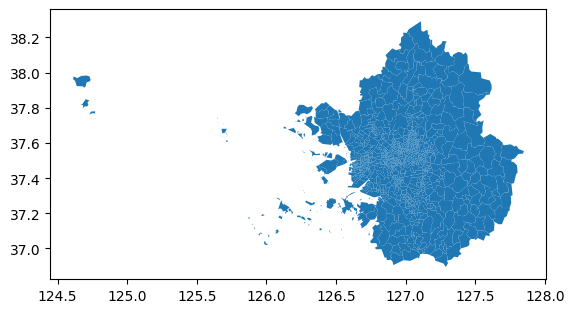

In [27]:
simplified_geometry.plot()

In [29]:
# Interactive Map
simplified_geometry.explore(tiles = 'CartoDB positron')

In [35]:
#### 출발 행정동 및 시간단위로 통행량 aggregation
df_agg = df.groupby(['O_ADMDONG_CD', 'ST_TIME_CD']).agg({'CNT': 'sum'}).reset_index()
df_agg

O_ADMDONG_CD  ST_TIME_CD     CNT
0          11110515           0   61.31
1          11110515           1  133.12
2          11110515           2  150.33
3          11110515           3   64.69
4          11110515           4   87.28
...             ...         ...     ...
53544      52800410          15    3.50
53545      52800420           9    3.48
53546      52800420          14    3.50
53547      52800420          15    3.72
53548      52800420          17    2.33

[53549 rows x 3 columns]

In [36]:
# 1. 먼저 pandas의 merge 함수를 사용하여 df_agg를 기준으로 병합
merged_df = df_agg.merge(simplified_geometry, 
                         left_on='O_ADMDONG_CD', 
                         right_on='ADMDONG_CD', 
                         how='inner')

# 2. 병합 결과를 GeoDataFrame으로 변환
vis_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs=simplified_geometry.crs)


In [43]:
vis_gdf[vis_gdf['ST_TIME_CD'] == 0].explore(column='CNT', 
                                            legend=True, 
                                            cmap='Reds', 
                                            tiles='CartoDB positron',
                                            style_kwds={'fillOpacity': 1, 'weight': 0.5})

## 2.2 Travel Time Data

- 지금까지는 통행량 데이터를 살펴보았습니다. 이 장에서는 통행시간 데이터를 살펴봅니다.
- 스마트카드(지하철,버스), 택시 탑승 및 호출 이력, 스마트폰 GPS 데이터 등 다양한 경로를 통해 여러분들의 이동 데이터가 수집되고 있습니다.
- 그 중 택시 데이터는 승차와 하차의 정확한 위치와 시간을 알 수 있다는 점에서 데이터의 신뢰성이 높습니다.
- 다양한 국가에서 이미 표준화된 형태의 택시 승하차 데이터를 공개하고 있습니다.
    - [Ney Yori City Taxi Trip Duration Data](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data)
    - [Chicago Taxi Trips data](https://data.cityofchicago.org/Transportation/Taxi-Trips-2013-2023-/wrvz-psew/about_data)
- 본 장에서는 서울의 택시 승하차 이력 데이터를 살펴보겠습니다. 다만, 국내의 경우 택시승하차 데이터가 오픈되어있지 않으므로, 여기선 가상의 데이터를 활용합니다.
    - 본 실습 데이터는 실제 데이터가 아니며, 분석을 위해 랜덤하게 생생된 1일치의 데이터입니다. 
    - 국내도 데이터 개방이 더 활성화 되어, 미국의 주요도시처럼 택시 및 스마트카드 데이터가 공개되는 날이 오기를 희망합니다.

### 2.2.1 데이터 읽기

In [16]:
def download_and_read_parquet(file_id, output_path="../data/chp2_od_data.parquet"):
    try:
        # Google Drive에서 파일 다운로드
        gdown.download(id=file_id, output=output_path, quiet=False)
        
        # Parquet 파일을 DataFrame으로 읽기
        df = pd.read_parquet(output_path)
        
        # 임시 파일 삭제 (데이터 용량이 매우 큰 경우 사용)
        os.remove(output_path) # 다운로드 받은 데이터를 삭제하고 싶지 않을 때는 해당 라인을 주석처리
        
        return df
    except Exception as e:
        print(f"오류 발생: {e}")
        return None

In [17]:
# 파일 불러오기
file_id = "1uJj-C_7pTkcRk8p5lYah-9Fp660OvS4b" # 구글 드라이브에 업로드 된 파일의 ID
tx_data = download_and_read_parquet(file_id)
# tx_data = pd.read_parquet('../data/chp2_tx_data_generated.parquet')

Downloading...
From (original): https://drive.google.com/uc?id=1uJj-C_7pTkcRk8p5lYah-9Fp660OvS4b
From (redirected): https://drive.google.com/uc?id=1uJj-C_7pTkcRk8p5lYah-9Fp660OvS4b&confirm=t&uuid=729c66b0-97ce-4dbc-9881-6ba3da9382a6
To: f:\mobility-simulation-book\data\chp2_od_data.parquet
100%|██████████| 23.1M/23.1M [00:01<00:00, 18.6MB/s]


- 데이터의 시간 형식이 숫자형태로 되어있다. 이렇게 되어있을 경우 보기가 불편하고, 시간단위 연산이 어렵기 때문에 시간 타입의 데이터로 변환해주는 것이 좋다

In [47]:
# 시간 데이터 형식 변횐
tx_data['RIDE_DTIME'] = pd.to_datetime(tx_data['RIDE_DTIME'], format="%Y%m%d%H%M%S")
tx_data['ALIGHT_DTIME'] = pd.to_datetime(tx_data['ALIGHT_DTIME'], format="%Y%m%d%H%M%S")

# 통행시간 계산
tx_data['TRAVEL_TIME'] = (tx_data['ALIGHT_DTIME'] - tx_data['RIDE_DTIME']) / pd.Timedelta(minutes=1)

In [48]:
tx_data

RIDE_DTIME  RIDE_POS_X  RIDE_POS_Y        ALIGHT_DTIME  \
0      2022-05-01 00:00:00  126.886907   37.482125 2022-05-01 00:07:04   
1      2022-05-01 00:00:00  126.960889   37.507369 2022-05-01 00:19:35   
2      2022-05-01 00:00:00  127.101762   37.467082 2022-05-01 00:13:08   
3      2022-05-01 00:00:00  127.055634   37.589778 2022-05-01 00:10:50   
4      2022-05-01 00:00:00  127.044648   37.567578 2022-05-01 00:03:57   
...                    ...         ...         ...                 ...   
597090 2022-05-01 23:59:58  126.908084   37.515114 2022-05-02 00:30:52   
597091 2022-05-01 23:59:59  127.001369   37.558880 2022-05-02 00:14:48   
597092 2022-05-01 23:59:59  127.002711   37.505298 2022-05-02 00:05:59   
597093 2022-05-01 23:59:59  127.131851   37.535969 2022-05-02 00:09:24   
597094 2022-05-01 23:59:59  126.908992   37.518746 2022-05-02 00:17:20   

        ALIGHT_POS_X  ALIGHT_POS_Y  TRAVEL_TIME  
0         126.896551     37.470549     7.066667  
1         127.113011     37.503858    19.583333  
2         127.052796     37.540526    13.133333  
3         127.087957     37.597224    10.833333  
4         127.037768     37.561673     3.950000  
...              ...           ...          ...  
597090    126.781716     37.486141    30.900000  
597091    127.034217     37.508548    14.816667  
597092    127.011192     37.492397     6.000000  
597093    127.160008     37.550329     9.416667  
597094    126.876963     37.477816    17.350000  

[597095 rows x 7 columns]

### 2.2.2 Basic Visualization

- 통행량 데이터와 마찬가지로 간단한 시각화를 해보자.
- 다음과 같은 오픈소스를 활용한다면 매끄럽게 시각화가 가능하다.
    - https://kepler.gl/
    - 데이터를 csv로 저장한 후, Kepler를 통해 시각화를 해보자.
    - [예시](https://kepler.gl/demo/map?mapUrl=https://dl.dropboxusercontent.com/scl/fi/8k0y58t4rceqvslmvhwyl/keplergl_7sjanmo.json?rlkey=8d6d24vw7l63t2bsch5cd53m9&dl=0)
- 통행시간의 경우 출발지-목적지(O-D) 단위로 통행시간을 시각화 하는 연습도 해보자.
    - O-D 단위의 시각화의 경우 무수히 많은 O-D pairs가 존재하기 때문에 시각적으로 표현하기가 매우 어렵다.
    - 또한, 지금 데이터의 공간단위가 이전에 다뤘던 행정구역과 같이 합산된 공간단위가 아니라, 세밀한 위경도 좌표로 표현되어 있기 때문에 더 어렵다.
    - 위와 같은 문제들을 어떻게 해결할 수 있을까? 

In [ ]:
tx_data.to_csv('../data/tx_data_generated.csv')

In [167]:
tx_data

RIDE_DTIME  RIDE_POS_X  RIDE_POS_Y        ALIGHT_DTIME  \
0      2022-05-01 00:00:00  126.886907   37.482125 2022-05-01 00:07:04   
1      2022-05-01 00:00:00  126.960889   37.507369 2022-05-01 00:19:35   
2      2022-05-01 00:00:00  127.101762   37.467082 2022-05-01 00:13:08   
3      2022-05-01 00:00:00  127.055634   37.589778 2022-05-01 00:10:50   
4      2022-05-01 00:00:00  127.044648   37.567578 2022-05-01 00:03:57   
...                    ...         ...         ...                 ...   
597090 2022-05-01 23:59:58  126.908084   37.515114 2022-05-02 00:30:52   
597091 2022-05-01 23:59:59  127.001369   37.558880 2022-05-02 00:14:48   
597092 2022-05-01 23:59:59  127.002711   37.505298 2022-05-02 00:05:59   
597093 2022-05-01 23:59:59  127.131851   37.535969 2022-05-02 00:09:24   
597094 2022-05-01 23:59:59  126.908992   37.518746 2022-05-02 00:17:20   

        ALIGHT_POS_X  ALIGHT_POS_Y  TRAVEL_TIME  
0         126.896551     37.470549     7.066667  
1         127.113011     37.503858    19.583333  
2         127.052796     37.540526    13.133333  
3         127.087957     37.597224    10.833333  
4         127.037768     37.561673     3.950000  
...              ...           ...          ...  
597090    126.781716     37.486141    30.900000  
597091    127.034217     37.508548    14.816667  
597092    127.011192     37.492397     6.000000  
597093    127.160008     37.550329     9.416667  
597094    126.876963     37.477816    17.350000  

[597095 rows x 7 columns]

## 2.3 Road Network and Geometry

### 2.3.1 Open Street Map 데이터 살펴보기

[오픈스트리트맵 한국](https://osm.kr/usage/)에서는 대한민국의 OSM을 이용하는 상세한 방법에 대한 메뉴얼을 제공해주고 있다. 상세한 내용은 이곳을 참고하면 되며, 본 장에서는 한국의 OSM 데이터를 불러와서 `OSMnx` 패키지로 간략히 분석하고 시각화 하는 작업을 진행한다. 

- OSM을 이용해서 수도권 지역의 도로 데이터를 가져오고, 시각화 하는 작업을 수행한다  
- OSMnx 이용해서 그래프 분석하고, 복잡한 그래프를 간소화 하는 작업을 실습한다

#### [1] Open Street Map 데이터 취득하기 (.osm.pbf 파일)
- 사이트 : https://download.geofabrik.de/asia.html
- South Korea 부분의 .osm.pbf 버튼 클릭
- 여기서 다운로드 받은 .osm.pbf 파일은 본 챕터에서는 사용하지 않지만 향후 Vehicle Router를 만들 때 활용한다. 

In [2]:
import networkx as nx
import osmnx as ox

ox.config(use_cache=True, log_console=True)
ox.__version__

C:\Users\rnt53\AppData\Local\Temp\ipykernel_33768\606638948.py:4: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)


'1.9.4'

#### [2] 내가 원하는 지역 osm 지도를 그래프 형태로 표현
- 본 실습에서는 `OSMnx` 패키지를 사용하여 원하는 도시의 Graph를 Python으로 가져와서 분석하는 실습을 진행한다.

In [24]:
# get a graph for some city
# www.openstreetmap.org에서 검색 결과가 city-state-country 단위로 나와야 함 

# # 서울특별시 전체 도로 네트워크 불러오기
# G = ox.graph_from_place('서울특별시, 대한민국', network_type='drive')

# osmnx 그래프 생성( osm 지도 다운로드 )
G = ox.graph_from_place('성남시, 경기도, 대한민국', network_type='drive')

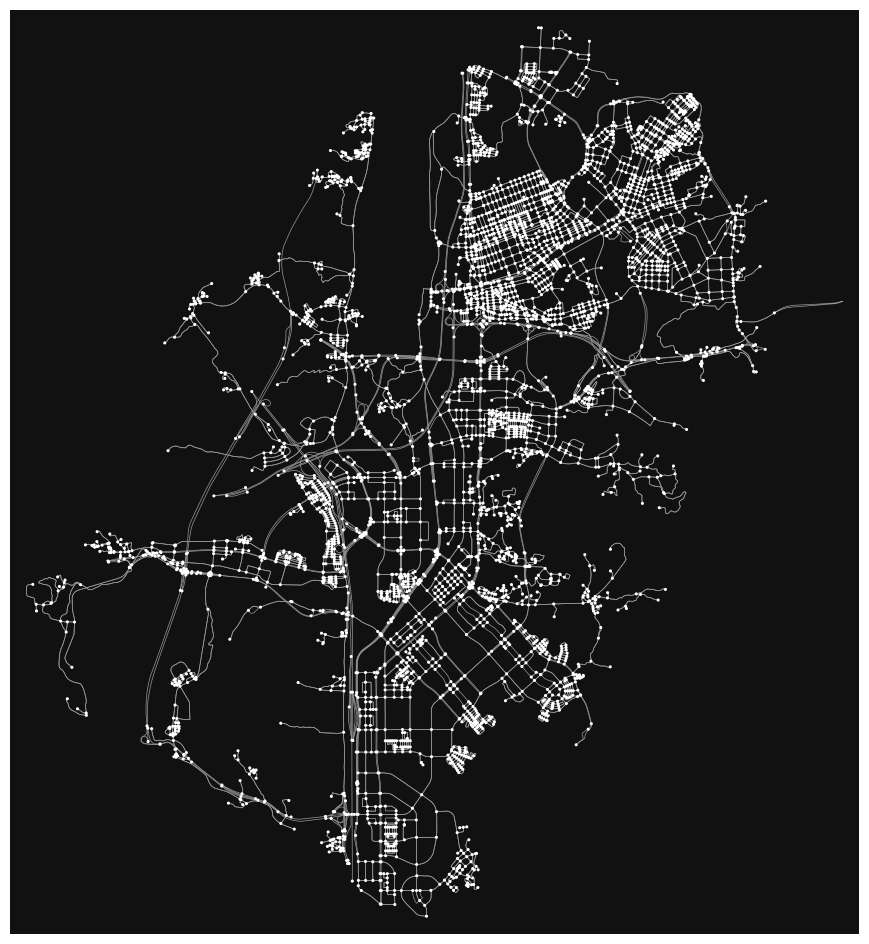

In [25]:
## 간단한 시각화
# fig, ax = ox.plot_graph(G)
fig, ax = ox.plot_graph(
                            G, 
                            figsize=(12, 12),
                            node_size=5, 
                            edge_linewidth=0.5
                        )

- 하지만 위와 같이 시각화를 한다면, static map이기 때문에 원하는 특정 지역을 세밀하게 관찰하기가 어렵다.  
- Interactive Map을 사용하면 속도는 더 느리지만, 보다 상세히 그래프를 살펴볼 수 있다. 

In [27]:
# 그래프의 중심점 계산
center_lat, center_lon = ox.geocode('성남시, 경기도, 대한민국')

# folium 맵 생성
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='cartodbpositron')

# 엣지(도로) 추가
for u, v, data in G.edges(data=True):
    locations = [(G.nodes[u]['y'], G.nodes[u]['x']), (G.nodes[v]['y'], G.nodes[v]['x'])]
    
    # 엣지(street) 정보 생성
    edge_info = f"도로명: {data.get('name', 'Unknown')}<br>" \
                f"길이: {data.get('length', 0):.2f} m<br>" \
                f"도로 유형: {data.get('highway', 'Unknown')}"
    
    folium.PolyLine(
        locations=locations,
        weight=2,
        color='blue',
        opacity=0.7,
        tooltip=edge_info
    ).add_to(m)

# 노드(교차점) 추가
for node, data in G.nodes(data=True):
    # 노드에 연결된 엣지 수 계산
    degree = G.degree(node)
    
    # 노드 정보 생성
    node_info = f"Node ID: {node}<br>" \
                f"위도: {data['y']:.6f}<br>" \
                f"경도: {data['x']:.6f}<br>" \
                f"연결된 도로 수: {degree}"
    
    folium.CircleMarker(
        location=(data['y'], data['x']),
        radius=3,
        popup=node_info,
        color='red',
        fill=True,
        fillColor='red',
        tooltip=f"Node ID: {node}"
    ).add_to(m)

# 맵 저장
m.save("../data/Sungnam_road_network_vis.html")

- 한가지 이상한 점이 있다. 모든 Egde가 직선으로표현되어, 실제 Basemap에 있는 도로와 정확하게 매칭되지 않는다
- Open Steet Map의 edge는 도로의 geometry 정보를 포함하고 있으며, 이 정보를 사용하면 실제도로와 유사하게 시각화가 가능하다

In [28]:
# folium 맵 생성 (CARTODB positron 베이스맵 사용)
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='cartodbpositron')

# 엣지(도로) 추가
for u, v, data in G.edges(data=True):
    if 'geometry' in data:
        # 실제 도로 지오메트리 사용
        geometry = data['geometry']
        coordinates = list(geometry.coords)
        locations = [(y, x) for x, y in coordinates]
    else:
        # 지오메트리 정보가 없는 경우 직선으로 표시
        locations = [(G.nodes[u]['y'], G.nodes[u]['x']), (G.nodes[v]['y'], G.nodes[v]['x'])]
    
    # 엣지(street) 정보 생성
    edge_info = f"도로명: {data.get('name', 'Unknown')}<br>" \
                f"길이: {data.get('length', 0):.2f} m<br>" \
                f"도로 유형: {data.get('highway', 'Unknown')}"
    
    folium.PolyLine(
        locations=locations,
        weight=2,
        color='blue',
        opacity=0.7,
        tooltip=edge_info
    ).add_to(m)

# 노드(교차점) 추가
for node, data in G.nodes(data=True):
    # 노드에 연결된 엣지 수 계산
    degree = G.degree(node)
    
    # 노드 정보 생성
    node_info = f"Node ID: {node}<br>" \
                f"위도: {data['y']:.6f}<br>" \
                f"경도: {data['x']:.6f}<br>" \
                f"연결된 도로 수: {degree}"
    
    folium.CircleMarker(
        location=(data['y'], data['x']),
        radius=3,
        popup=node_info,
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.7,
        tooltip=f"Node ID: {node}"
    ).add_to(m)

# 맵 저장
m.save("../data/Sungnam_road_network_vis_with_geometry.html")

#### [3] 여러 네트워크를 한번에 표시

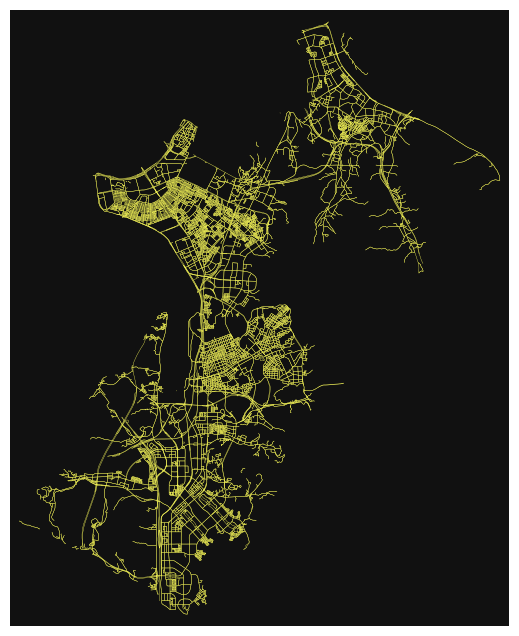

In [10]:
# 여러 위치에서 네트워크를 생성하기 위한 서울 지역 리스트 설정
places = [
    '성남시, 경기도, 대한민국',  
    '송파구, 서울특별시, 대한민국',  
    '하남시, 경기도, 대한민국',  
]

# retain_all=True를 사용하여 모든 연결되지 않은 서브그래프도 유지 (연속된 네트워크가 아닌 경우에도 유지)
# 여러 장소를 기반으로 차량 도로 네트워크(network_type="drive")를 생성
G = ox.graph_from_place(places, network_type="drive", retain_all=True)

# 생성된 네트워크 시각화 
fig, ax = ox.plot_graph(
    G,                      
    node_size=0,           
    edge_color="#FFFF5C",    
    edge_linewidth=0.25      
)

#### [4]  기초적인 도로네트워크 속성 파악 및 시각화

In [11]:
# osmnx 그래프 생성( osm 지도 다운로드 )
G = ox.graph_from_place('성남시, 경기도, 대한민국', network_type='drive')

In [13]:
# 기본 그래프 정보 출력
print("노드 수:", len(G.nodes))
print("엣지 수:", len(G.edges))

노드 수: 4713
엣지 수: 12745


`OSMnx` 패키지에 있는 `basic_stats`라는 함수를 사용하면 기본적인 네트워크 통계를 출력해준다. 아래와 같은 정보들이 포함된다. 

- **n: 그래프의 총 노드 수**
- **m: 그래프의 총 엣지 수**
- **k_avg: 평균 노드 차수 (한 노드에 연결된 평균 엣지 수)**
- **edge_length_total: 모든 엣지 길이의 총합 (미터 단위)**
- edge_length_avg: 평균 엣지 길이 (미터 단위)
- **streets_per_node_avg: 노드당 평균 Street 수**
- streets_per_node_counts: 각 Street수별 노드 개수 (예: 3개의 거리가 만나는 교차로의 수)
- streets_per_node_proportions: 각 Street 수별 노드 비율
- **intersection_count: 교차로의 총 개수**
- **street_length_total: 모든 거리의 총 길이 (미터 단위)**
- **street_segment_count: 거리 세그먼트의 총 개수**
- street_length_avg: 평균 Street 길이 (미터 단위)
- circuity_avg: 평균 우회도 (직선 거리 대비 실제 거리의 비율)
- self_loop_proportion: 자기 루프(같은 노드로 시작하고 끝나는 엣지)의 비율

In [43]:
# 기본 네트워크 통계 계산 및 출력
stats = ox.basic_stats(G)
print("\n기본 네트워크 통계:")
for key, value in stats.items():
    print(f"{key}: {value}")


기본 네트워크 통계:
n: 4713
m: 12745
k_avg: 5.408444727349884
edge_length_total: 1601319.117000001
edge_length_avg: 125.6429279717537
streets_per_node_avg: 3.0693825588796946
streets_per_node_counts: {0: 0, 1: 406, 2: 25, 3: 3149, 4: 1103, 5: 29, 6: 1}
streets_per_node_proportions: {0: 0.0, 1: 0.08614470613197539, 2: 0.005304476978569913, 3: 0.6681519202206663, 4: 0.23403352429450455, 5: 0.0061531932951410994, 6: 0.0002121790791427965}
intersection_count: 4307
street_length_total: 986186.3729999983
street_segment_count: 7200
street_length_avg: 136.9703295833331
circuity_avg: 1.065962469699925
self_loop_proportion: 0.0022222222222222222


보다 세부적으로 Node와 Edge들이 어떤 속성을 가지고 있는지 알아보자.  
기본적으로 Graph의 Node와 Edge는 ~~~ 형태의 데이터 포맷을 가지고 있다. Python에서 보다 쉽게 이를 보기 위해서 Dataframe으로 변환하면 좋다. 

Node의 속성:
- Node ID: 노드의 고유 식별자 (일반적으로 OSM의 ID)
- x, y 좌표: 노드의 경도(longitude, x)와 위도(latitude, y)
- 기타 속성: 노드가 속한 구역의 정보 등 다양한 부가 정보가 포함될 수 있습니다.



In [49]:
# 처음 20개의 노드만 선택
sample_nodes = list(G.nodes(data=True))[:20]

# 각 노드의 특성을 딕셔너리 리스트로 변환
node_data = []
for node, data in sample_nodes:
    node_info = {'node_id': node}  # 노드의 고유 ID 추가
    node_info.update(data)  # 노드의 기타 속성 추가 (x, y 좌표 등)
    node_data.append(node_info)

# DataFrame으로 변환
node_df = pd.DataFrame(node_data)
node_df

node_id          y           x  street_count          highway
0   414689872  37.462244  127.155179             4              NaN
1   414689878  37.422383  127.102033             4  traffic_signals
2   414689917  37.440888  127.131794             4              NaN
3   414689923  37.409577  127.124802             4              NaN
4   414689924  37.405432  127.123595             4              NaN
5   414689925  37.405433  127.125451             4              NaN
6   414689927  37.399175  127.125408             4              NaN
7   414689930  37.409160  127.123032             4              NaN
8   414689935  37.413087  127.120808             4              NaN
9   414689936  37.413800  127.122542             4              NaN
10  414689939  37.407399  127.133922             3              NaN
11  414689940  37.408093  127.142963             4              NaN
12  414689943  37.428234  127.137920             4              NaN
13  414689944  37.429750  127.137140             4              NaN
14  414689946  37.432220  127.167570             3              NaN
15  414689949  37.436372  127.158149             4              NaN
16  414689950  37.433378  127.159984             4              NaN
17  414689951  37.443884  127.157849             4              NaN
18  414689953  37.445126  127.156678             4              NaN
19  414689954  37.452315  127.149288             3  traffic_signals

In [50]:
# 모든 node의 데이터를 가져옴
nodes = list(G.nodes(data=True))

# node에서 highway 속성만을 추출하여 리스트 생성
highway_types = []
for node_id, data in nodes:
    if 'highway' in data:
        highway_types.append(data['highway'])  # highway 속성이 있으면 리스트에 추가

# highway 타입별 개수 세기
highway_counts = pd.Series(highway_types).value_counts()
highway_counts

traffic_signals      143
motorway_junction     19
crossing               8
turning_circle         7
mini_roundabout        2
proposed               1
Name: count, dtype: int64

Edge의 속성:
- start_node, end_node: edge가 연결하는 두 노드의 ID
- length: edge의 길이 (단위는 보통 미터)
- highway type: 도로 유형 (예: residential, primary 등)
- geometry: 도로의 곡선 정보 (라인스트링 형태로 저장)
- oneway: 도로가 일방통행인지 여부

In [51]:
# 처음 5개의 엣지만 선택
sample_edges = list(G.edges(data=True))[:20]

# 각 엣지의 특성을 딕셔너리 리스트로 변환
edge_data = []
for u, v, data in sample_edges:
    edge_info = {'start_node': u, 'end_node': v}
    edge_info.update(data)
    edge_data.append(edge_info)

# DataFrame으로 변환
df = pd.DataFrame(edge_data)
df


start_node     end_node                              osmid  oneway  \
0    414689872  10712317417                         1151530545    True   
1    414689872   4809139436                           54607084   False   
2    414689872   2684209530                          220199776    True   
3    414689878   4299327239                          829530778   False   
4    414689878   1668416833                          829530778   False   
5    414689878   4299327232                           70986684    True   
6    414689917   6293360179                           60609785    True   
7    414689917    759684094                          218842461    True   
8    414689923   2939333063                          186410776   False   
9    414689923   1970949890                          522869003   False   
10   414689923    414689930    [86191984, 522869004, 86191992]   False   
11   414689923   1970949905                          522869005   False   
12   414689924    414689925    [86192896, 277593627, 86192892]   False   
13   414689924   4299773324                          435950146   False   
14   414689924   4299773322                          523170415   False   
15   414689924   4299773320                          523170416   False   
16   414689925   4264953671                           86192896   False   
17   414689925    414689924    [86192896, 277593627, 86192892]   False   
18   414689925   1970949852                          186410765   False   
19   414689925   4272268329  [186410730, 522869003, 186410765]   False   

           highway       reversed   length  ref   name  \
0   secondary_link          False   10.895  NaN    NaN   
1        secondary          False   36.738  342  남한산성로   
2        secondary          False   53.796  342    수정로   
3        secondary          False   51.101   23  대왕판교로   
4        secondary           True   15.431   23  대왕판교로   
5       trunk_link          False   52.085  NaN    NaN   
6         tertiary          False   49.945  NaN    제일로   
7         tertiary          False    2.893  NaN    수정로   
8         tertiary           True  204.641  NaN    양현로   
9         tertiary          False   58.064  NaN    양현로   
10        tertiary          False  163.040  NaN    야탑로   
11        tertiary           True  111.403  NaN    야탑로   
12        tertiary  [False, True]  163.927  NaN    판교로   
13        tertiary           True   61.039  NaN    탄천로   
14        tertiary          False   60.780  NaN    탄천로   
15        tertiary          False  181.874  NaN    판교로   
16        tertiary          False  143.716  NaN    판교로   
17        tertiary  [False, True]  163.927  NaN    판교로   
18        tertiary          False   62.327  NaN    양현로   
19        tertiary           True  305.256  NaN    양현로   

                                             geometry lanes bridge  
0                                                 NaN   NaN    NaN  
1   LINESTRING (127.1551794 37.4622445, 127.155167...   NaN    NaN  
2   LINESTRING (127.1551794 37.4622445, 127.155156...   NaN    NaN  
3                                                 NaN     8    NaN  
4                                                 NaN     8    NaN  
5   LINESTRING (127.102033 37.4223826, 127.1019343...   NaN    NaN  
6                                                 NaN   NaN    NaN  
7                                                 NaN   NaN    NaN  
8   LINESTRING (127.1248017 37.4095773, 127.124729...     4    NaN  
9   LINESTRING (127.1248017 37.4095773, 127.124879...     4    NaN  
10  LINESTRING (127.1248017 37.4095773, 127.124601...     4    yes  
11  LINESTRING (127.1248017 37.4095773, 127.125026...     4    NaN  
12  LINESTRING (127.1235955 37.4054319, 127.123820...     6    yes  
13  LINESTRING (127.1235955 37.4054319, 127.123586...     4    NaN  
14  LINESTRING (127.1235955 37.4054319, 127.123596...     4    NaN  
15  LINESTRING (127.1235955 37.4054319, 127.123418...     6    NaN  
16  LINESTRING (127.1254512 37.4054332, 127.125653...    

OSM에서 도로 타입이 총 몇가지로 구분이 되는지 알아보려면 아래와 같이 할 수 있다.  
매우 많은 도로유형이 있는 것을 알 수 있다. 각각의 상세한 설명 및 기준이 궁금하면 다음을 참고하자. https://wiki.openstreetmap.org/wiki/Key:highway

In [52]:
# 모든 edge의 데이터를 가져옴
edges = list(G.edges(data=True))

# highway 속성만을 추출하여 리스트 생성
highway_types = []
for u, v, data in edges:
    if 'highway' in data:
        # 일부 엣지의 highway 속성이 리스트일 수 있어 처리
        if isinstance(data['highway'], list):
            highway_types.extend(data['highway'])
        else:
            highway_types.append(data['highway'])

# highway 타입별 개수 세기
highway_counts = pd.Series(highway_types).value_counts()
highway_counts

residential       7929
tertiary          2704
unclassified       861
primary            295
secondary          201
tertiary_link      180
living_street      137
trunk_link         116
primary_link       113
motorway_link       90
secondary_link      61
trunk               56
motorway            38
road                12
Name: count, dtype: int64

### 2.3.2 최단거리 분석

- 두 지점까지의 거리를 추출하는 것은 교통 데이터를 분석할 때 매우 빈번히 쓰인다
- 가장 간단한 것은 직선거리를 추출하는 것이지만, 실제 도로위를 움직이는 차량이나 사람의 움직임과는 큰 차이를 보인다.

#### [1] 두 지점간 Network Distance 구하기 실습

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium

%matplotlib inline

In [ ]:
# pip install scikit-learn
# pip install folium
# pip install scipy

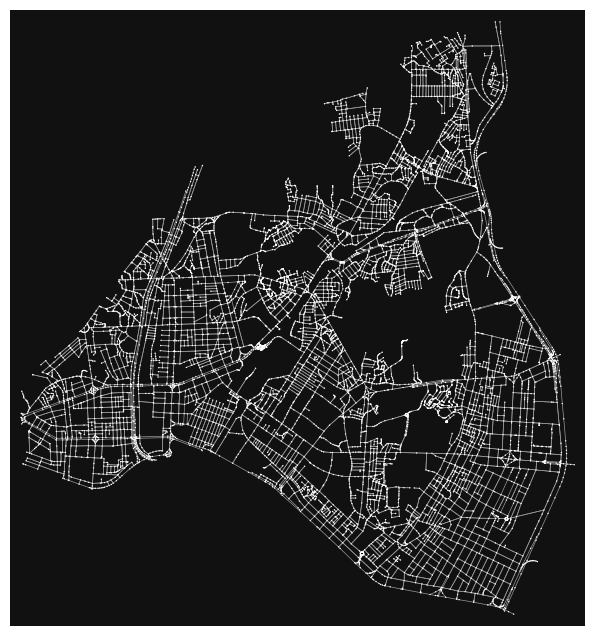

In [ ]:
# 원하는 지역 그래프 생성
G = ox.graph_from_place('동대문구, 서울, 대한민국', network_type='drive', simplify=False)

# 그래프 시각화
fig, ax = ox.plot_graph(
                            G, 
                            figsize=(8, 8),
                            node_size=1, 
                            edge_linewidth=0.5
                        )

In [ ]:
# 출발지 도착지 좌표 설정( 좌표와 가장 가까운 노드를 찾아줌 )
orig_node = ox.nearest_nodes(G, 127.0462200, 37.5804100) #청량리역
dest_node = ox.nearest_nodes(G, 127.0114887, 37.5718616) #동대문역

In [ ]:
# 최단 거리 경로 추출
route = nx.shortest_path(G, orig_node, dest_node, weight='length')

In [ ]:
# 최단 거리 추출
len = nx.shortest_path_length(G, orig_node, dest_node, weight='length') / 1000
print(round(len, 1), "킬로미터")

2.9 킬로미터


In [ ]:
# 촤단거리 지도 생성
route_graph_map = ox.plot_route_folium(G, route, popup_attribute='length')
    
# 출발지와 목적지 좌표
orig_node_xy = (G.nodes[orig_node]['y'], G.nodes[orig_node]['x'])  # (위도, 경도)
dest_node_xy = (G.nodes[dest_node]['y'], G.nodes[dest_node]['x'])  # (위도, 경도)

# 출발지 마커 추가
folium.Marker(location=orig_node_xy, popup='출발지', icon=folium.Icon(color='green')).add_to(route_graph_map)

# 목적지 마커 추가
folium.Marker(location=dest_node_xy, popup='목적지', icon=folium.Icon(color='red')).add_to(route_graph_map)

# 지도 시각화
route_graph_map

# 지도 저장 
# filepath = 'data/route_graph.html' # 경로 지정
# route_graph_map.save(filepath)

C:\Users\alstn\AppData\Local\Temp\ipykernel_7400\861946550.py:2: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  route_graph_map = ox.plot_route_folium(G, route, popup_attribute='length')


#### [2] 이동 속도 및 시간 영향을 고려한 경로 산출

In [ ]:
# 위의 그래프의 모든 엣지에 속도를 부여
G = ox.add_edge_speeds(G)

# 모든 에지에 대한 이동 시간(초) 계산
G = ox.add_edge_travel_times(G)

In [ ]:
# 도로 유형별 평균 속도/시간 값 보기
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

length  speed_kph  travel_time
highway                                       
living_street     22.2       44.6          1.8
primary           31.5       56.2          2.0
primary_link      12.7       30.0          1.5
residential       27.5       30.4          3.3
secondary         31.7       42.5          2.7
secondary_link    16.5       46.2          1.3
tertiary          34.6       30.7          4.1
tertiary_link     20.9       44.6          1.7
trunk             54.0       76.1          2.5
trunk_link        24.1       44.6          1.9

In [ ]:
# 도로 별 속도 지정
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60} # residential : 주거지도로 secondary : 지방도 tertiary: 시도·군도·구도
G = ox.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.add_edge_travel_times(G)

In [ ]:
# 이동 거리와 이동 시간을 최소화한 두 가지 경로를 계산합니다

# 그래프 내에서 출발지 목적지 가져오기
orig = list(G)[1]
dest = list(G)[111]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

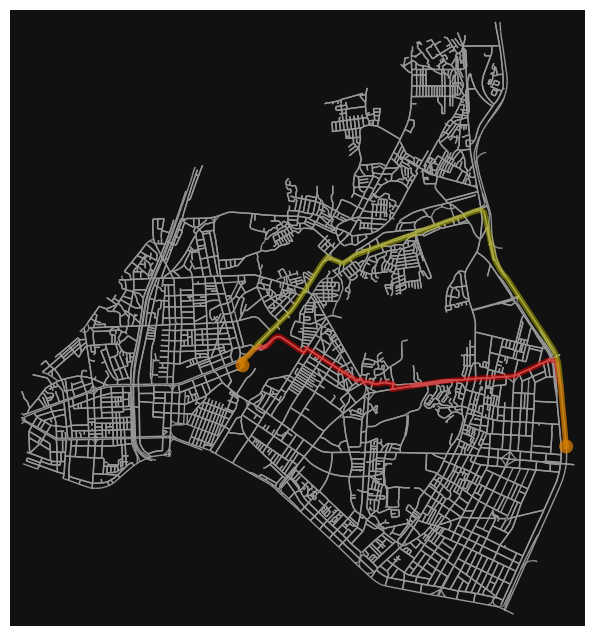

In [ ]:
# 시각화
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [ ]:
# 두 경로 비교

# route1의 길이 계산 (거리 기준 최적 경로의 총 길이, 단위: 미터)
route1_length = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["length"]))

# route2의 길이 계산 (시간 기준 최적 경로의 총 길이, 단위: 미터)
route2_length = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["length"]))

# route1의 소요 시간 계산 (거리 기준 최적 경로의 총 소요 시간, 단위: 초)
route1_time = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["travel_time"]))

# route2의 소요 시간 계산 (시간 기준 최적 경로의 총 소요 시간, 단위: 초)
route2_time = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["travel_time"]))

# 두 경로의 길이와 소요 시간을 출력
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")


Route 1 is 3897 meters and takes 325 seconds.
Route 2 is 4942 meters and takes 300 seconds.


#### [3] 특정 노드에서 지정한 거리/시간에 도달할 수 있는 노드 분석( 버퍼 )

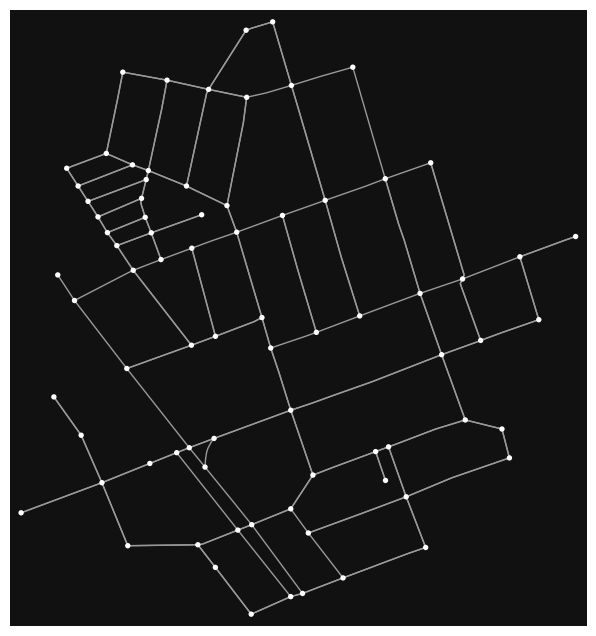

In [ ]:
# 도로 네트워크 불러오기
G = ox.graph_from_place('Gangnam, Seoul, South Korea', network_type='drive')

# 특정 노드를 선택 (예: 첫 번째 노드를 선택)
center_node = list(G.nodes)[0]

# 특정 노드를 중심으로 반경 500m 내의 서브그래프를 ego_graph로 추출
radius = 500  # 반경 (미터 단위)
ego_G = nx.ego_graph(G, center_node, radius=radius, distance='length')

# 서브그래프를 시각화
fig, ax = ox.plot_graph(ego_G)

### 2.3.3 Graph 간소화

c:\Users\alstn\AppData\Local\Programs\Python\Python38\lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


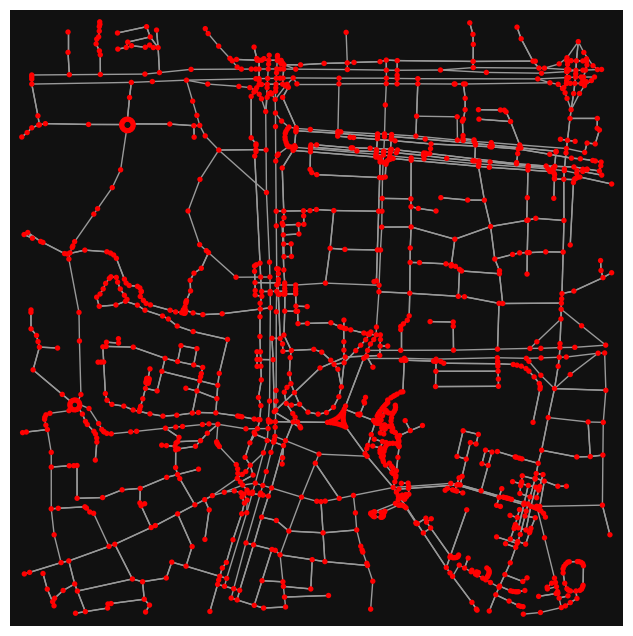

In [ ]:
# 중심 위치 지점(위도, 경도) 정의 ( 서울 시청 )
location_point = (37.5665, 126.9780)

# 중심 위치로부터 500미터 거리 내에서 도로 네트워크 생성
# simplify=False로 설정하여 네트워크를 아직 단순화하지 않음
G = ox.graph_from_point(location_point, dist=500, simplify=False)

# 단순화되지 않은 네트워크 그래프를 플로팅. 노드는 빨간색(r)으로 표시됨
fig, ax = ox.plot_graph(G, node_color="r")

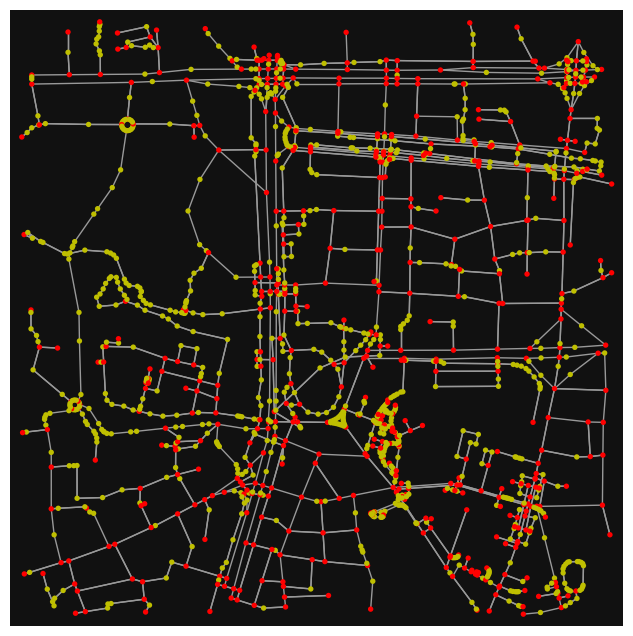

In [ ]:
# 네트워크가 단순화될 때 제거될 노드를 강조
# 끝점인 노드는 빨간색(r)으로 남고, 끝점이 아닌 노드는 노란색(y)으로 표시됨
nc = ["r" if ox.simplification._is_endpoint(G, node, None) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

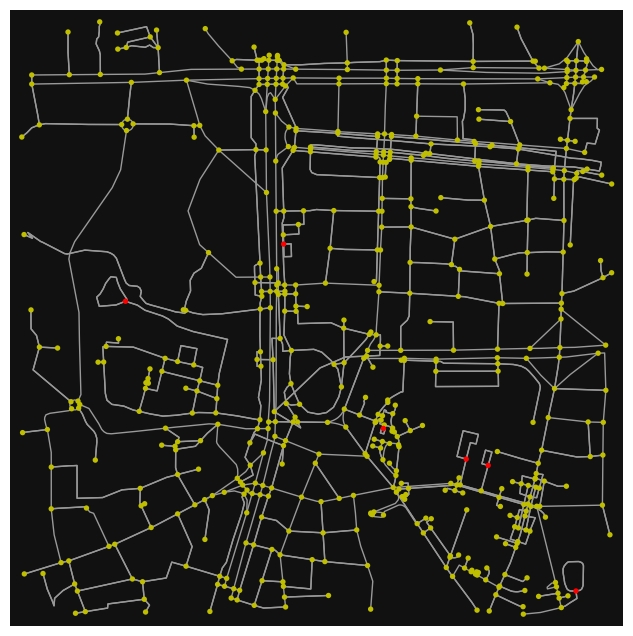

In [ ]:
# 네트워크를 단순화하여 불필요한 중간 노드를 병합
# 위의 노란색 점 제거
G2 = ox.simplify_graph(G)

# 단순화된 그래프에서 자기 루프(self-loop) 엣지와 연결된 노드를 강조
# 자기 루프 엣지는 노드가 자기 자신과 연결되는 엣지임. 이런 노드는 빨간색(r)으로,
# 나머지 노드는 노란색(y)으로 표시됨
loops = [edge[0] for edge in nx.selfloop_edges(G2)]
nc = ["r" if node in loops else "y" for node in G2.nodes()]
fig, ax = ox.plot_graph(G2, node_color=nc)

- strict 모드는 엣지 속성이 서로 다르면 다른 도로로 간주하고 병합하지 않음
- strict 모드 해제는 일부 엣지 속성의 차이를 무시하고, 엣지가 달라도 연결 가능한 도로로 처리하겠다는 뜻

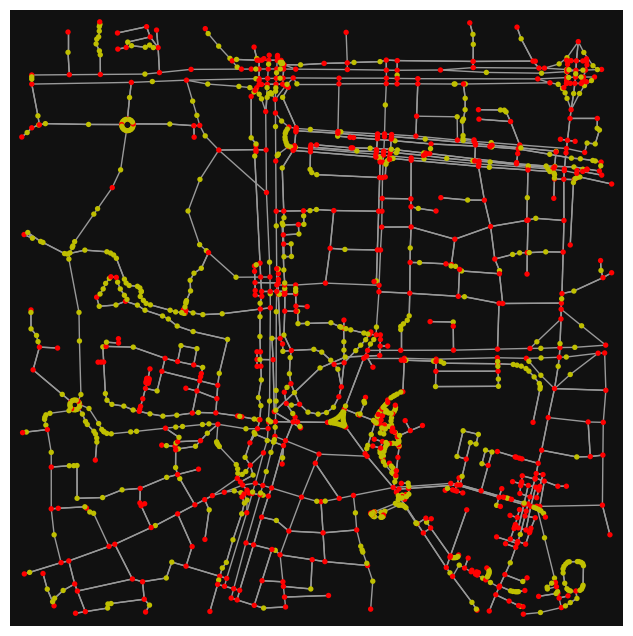

In [ ]:
# 이제 strict 모드를 해제하고, 엣지 속성의 차이를 허용하도록 설정
# 엣지 매칭 조건을 완화했을 때 제거될 노드를 확인

# 각 노드에 대해 끝점 여부를 판단하여, 끝점인 경우 빨간색(r), 끝점이 아닌 경우 노란색(y)으로 표시
nc = [
    "r" if ox.simplification._is_endpoint(G, node, ["osmid"]) else "y" for node in G.nodes() # osmid : OpenStreetMap ID -> 도로 판별 기준점
]

# 시각화화
fig, ax = ox.plot_graph(G, node_color=nc)

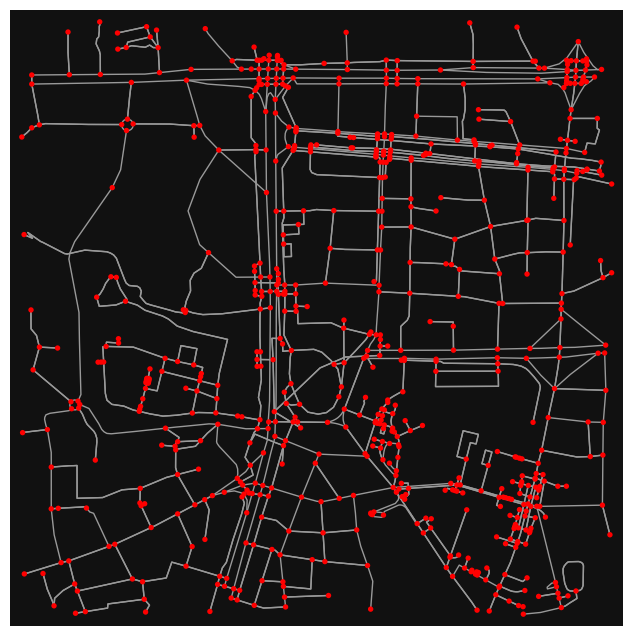

In [ ]:
# strict 모드를 해제한 상태로 다시 네트워크 단순화
# `edge_attrs_differ` 파라미터를 통해 특정 엣지 속성 차이를 무시하며 단순화함 (예: 'osmid')
# 위의 노란색 점 제거
G3 = ox.simplify_graph(G.copy(), edge_attrs_differ=["osmid"])

# strict 모드가 해제된 단순화된 네트워크를 플로팅, 모든 노드는 빨간색(r)으로 표시됨
fig, ax = ox.plot_graph(G3, node_color="r")

## 2.4 GTFS (General Transit Feed Specification)

- 대중교통 네트워크 분석을 위한 데이터
- 향후 업데이트 예정
- 금 학기에서는 다루지 않음

## 2.5 Exercise

GPT와 같은 AI 툴을 적극 활용해 문제를 풀어봅시다. 다만, 출력된 코드를 보고 이해하고, 코드가 실행되지 않는다면 어디서 실행되지 않는지 파악하고 올바르게 수정할 수 있어야 합니다.

### 2.5.1 통행 수요 데이터 분석 및 시각화

> 2.1 Section에서 불러온 2024년 3월 27일 통행 데이터를 가지고 아래와 같은 분석을 수행해보자.

1. 시간에 따른 통행량을 그래프로 시각화 해보자. 몇시에 통행이 가장 많으며, 그 양은 얼마인가?  
2. 공간에 따른 통행량의 분포를 읍면동 단위로 시각화 해보자. 어느 지역에서 출발 통행량(Trip Production)이 가장 많으며 어느 지역에서 도착 통행량 (Trip Attraction)이 가장 많은가?  
3. 통행의 시공간적 분포를 함께 분석해보자. 가장 효과적인 시각화 방안은 무엇일까?  
4. 출발통행, 도착통행이 아닌, 출발지-목적지간의 통행을 시각화 해보자. O-D pairs의 수가 지나치게 많다면 이를 효과적으로 시각화 할 수 있을까? 어떤 패키지나 소프트웨어를 활용하면 좋을지 고민해보자. 

### 2.5.2 통행 시간 데이터 분석 및 시각화

> 2.2 Section에서 불러온 가상의 택시 통행 데이터를 가지고 아래와 같은 분석을 수행해보자.

1. 택시 통행 데이터의 각 행에, 출발지역의 행정동 코드를 매핑해봅시다. 이후 아래문제를 풀어보세요. `geopandas` 패키지에 있는  `sjoin` 함수를 사용하면 됩니다. 
2. 청담동에서 출발해서 연희동 도착하는 택시 통행만을 추출하여, 시간대별 통행시간의 변화를 Line Graph로 그려봅시다. 언제 가장 시간이 오래 걸리나요?  